# Sentiment Analysis

Sentiment analysis, also called opinion mining, is a technique used in Natural Language Processing to automatically extract the sentiment behind a piece of text. It's usually used to help businesses understand the social sentiment users/customers feel about their products, services and brand.

Basically, sentiment analysis is a text classification problem. In most cases we are trying to classify text into either positive, neutral or negative classes. These classes however, depend on how we would like to categorize the text. It could be taken a step further where also feelings (happiness, anger, sadness, etc) can be approximated. 

However, just labeling reviews or user feedback based on these categories doesn't give business owners any actionable insights on how to improve their product and satisfy customers. That's where Aspect-based sentiment analysis (ABSA) comes in. It's helps determine which feature (or aspect) people are mentioning and how they feel about it. For example, A product review reads: "The loading times are too long". In this case the aspect being mentioned is "loading time" and the sentiment behind it is negative ("too long). This is what an ABSA classifier would be able to determine.

## EasyPark NPS Surveys

In this project we'll be looking into EasyPark, a mobile app which helps you find and pay for parking spaces. EasyPark conducted an NPS (Net Promoter Score) survey, in order to see how likely their users would recommend the app to others on a scale of 1 to 10. The users had the option to leave feedback on the app. this is what we will be looking into today and conduct a sentiment analysis to help EasyPark improve their service.

Let's start by importing all the libraries we'll be needing fro this analysis

In [280]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from googletrans import Translator

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from nltk.stem import WordNetLemmatizer
from sklearn.compose import ColumnTransformer

import contractions
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
import nltk
import string

# show all columns of dataframe
pd.set_option('display.max_columns', None)

I have the data saved as a CSV file which I will now load in
- TODO: Replace this with a direct connection to the GCP table

In [1123]:
# load data
df_ep_nps = pd.read_csv("../raw_data/EasyPark_Braze_For_Moahmed.csv", low_memory=False)
df_ep_nps.head()

,campaign,user_id,nps_rating,nps_detractors_feedback,business_unit,language,platform,country,home_country,app_rating_committed,pre_rating,post_rating_feedback,date,csat_segment,csat_b2ccoms_content,csat_b2ccoms_channel,csat_b2ccoms_frequency,csat_b2ccoms_feedback,client_name,nps_answer,nps_survey
0,App Rating survey,iXEarPyfGaNwYJm7BkZ+CluEbQYlHsTKLxDAt0LTOU/1TS...,NaN,NaN,NaN,sv,ios,SE,SE,NaN,thumbs-up,NaN,2021-12-01,NaN,NaN,NaN,NaN,NaN,easypark,NaN,NaN
1,App Rating survey,kRab2LpLHAv9ape9mj8zaz0yiJJts29Obw9gz89VSBGfUh...,NaN,NaN,NaN,sv,ios,SE,SE,NaN,thumbs-up,NaN,2021-12-01,NaN,NaN,NaN,NaN,NaN,easypark,NaN,NaN
2,App Rating survey,TUmw7VgjjzodCAR8fWRVC9PlXuVMCHiao2Hnujt1fHUNV0...,NaN,NaN,NaN,sv,ios,SE,SE,NaN,thumbs-up,NaN,2021-12-01,NaN,NaN,NaN,NaN,NaN,easypark,NaN,NaN
3,App Rating survey,faODXjq0AEf+LZ8DVd1fQq7kSSvURyKvHyKpTyp6OG5FwD...,NaN,NaN,NaN,sv,ios,SE,SE,NaN,thumbs-up,NaN,2021-12-01,NaN,NaN,NaN,NaN,NaN,easypark,NaN,NaN
4,App Rating survey,EG3DjAi/+wLz+Ni+jyCqou1gAibizWp/1OP2UbOcwsYpf9...,NaN,NaN,NaN,sv,ios,SE,SE,NaN,thumbs-up,NaN,2021-12-01,NaN,NaN,NaN,NaN,NaN,easypark,NaN,NaN


## Simple EDA

Lets do a simple exploratory data analysis to get a sense of the dataset and overall statistics

In [21]:
df_ep_nps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1385483 entries, 0 to 1385482
Data columns (total 21 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   campaign                 1385483 non-null  object 
 1   user_id                  1384721 non-null  object 
 2   nps_rating               12139 non-null    float64
 3   nps_detractors_feedback  216 non-null      object 
 4   business_unit            12176 non-null    object 
 5   language                 1385477 non-null  object 
 6   platform                 1384863 non-null  object 
 7   country                  1385483 non-null  object 
 8   home_country             1373947 non-null  object 
 9   app_rating_committed     66585 non-null    object 
 10  pre_rating               1353595 non-null  object 
 11  post_rating_feedback     8566 non-null     object 
 12  date                     1385483 non-null  object 
 13  csat_segment             17095 non-null   

In [22]:
df_ep_nps.describe()

,nps_rating,csat_b2ccoms_content,csat_b2ccoms_channel,csat_b2ccoms_frequency,nps_answer,nps_survey
count,12139.000000,11258.000000,10206.000000,9615.000000,0.0,0.0
mean,8.886234,4.364807,4.381050,4.341966,NaN,NaN
std,2.147853,1.009185,0.974496,1.004029,NaN,NaN
min,0.000000,1.000000,1.000000,1.000000,NaN,NaN
25%,8.000000,4.000000,4.000000,4.000000,NaN,NaN
50%,10.000000,5.000000,5.000000,5.000000,NaN,NaN
75%,10.000000,5.000000,5.000000,5.000000,NaN,NaN
max,10.000000,5.000000,5.000000,5.000000,NaN,NaN


Check for missing values

In [23]:
df_ep_nps.isnull().sum()

campaign                         0
user_id                        762
nps_rating                 1373344
nps_detractors_feedback    1385267
business_unit              1373307
language                         6
platform                       620
country                          0
home_country                 11536
app_rating_committed       1318898
pre_rating                   31888
post_rating_feedback       1376917
date                             0
csat_segment               1368388
csat_b2ccoms_content       1374225
csat_b2ccoms_channel       1375277
csat_b2ccoms_frequency     1375868
csat_b2ccoms_feedback      1384500
client_name                      0
nps_answer                 1385483
nps_survey                 1385483
dtype: int64

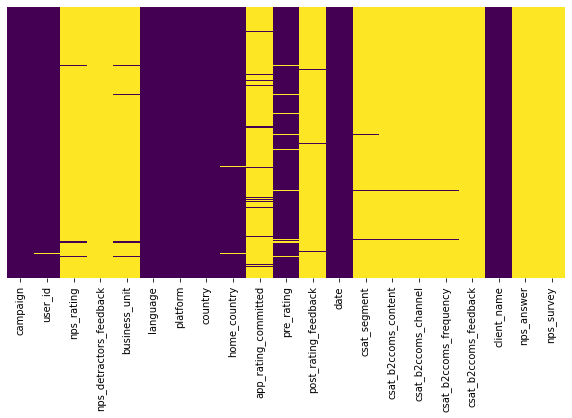

In [24]:
plt.figure(figsize=(10, 5))
sns.heatmap(df_ep_nps.isnull(),
        yticklabels=False,
        cbar=False,
        cmap='viridis')
plt.show()

There are a lot of missing values in the dataset. We'll have to do some data cleaning before we can start the sentiment analysis

Let's check the timeline of the survey and how many surveys were sent out to users per day

In [25]:
# convert "date" column to datetime
df_ep_nps["date"] = pd.to_datetime(df_ep_nps["date"], format="%Y-%m-%d")
print(df_ep_nps["date"].min(), df_ep_nps["date"].max())

2021-01-15 00:00:00 2022-04-06 00:00:00


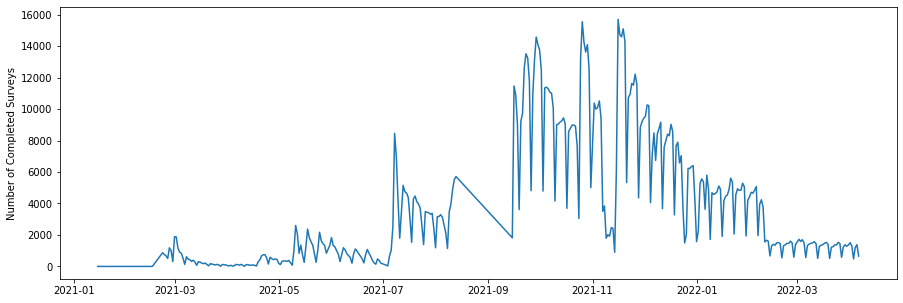

In [26]:
# plot number of surveys conducted per day
df_survery_per_day = df_ep_nps.groupby(df_ep_nps["date"], as_index=False).count()[["date", "campaign"]]

fig = plt.figure(figsize = (15, 5))
sns.lineplot(data=df_survery_per_day, x="date", y="campaign")
plt.xlabel("")
plt.ylabel("Number of Completed Surveys");

In [27]:
# check platforms
df_ep_nps["platform"].unique()

array(['ios', 'android', nan, 'web', 'iOS', 'Android', 'Web'],
      dtype=object)

We have duplicate categories that were spelled differently (with and without uppercase). Lets make sure that all categories have the same spelling convention.

In [28]:
# convert to lower case
df_ep_nps["platform"] = df_ep_nps["platform"].str.lower()

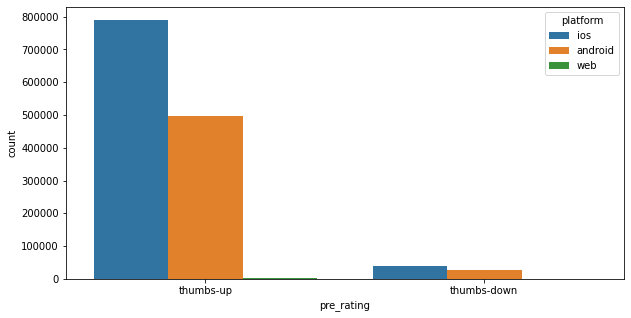

In [29]:
# plot pre ratings by platform
fig = plt.figure(figsize = (10, 5))
plt.ticklabel_format(style='plain', axis='y')
sns.countplot(data=df_ep_nps, x="pre_rating", hue="platform");

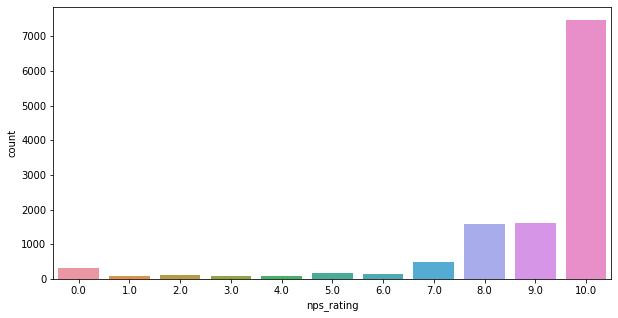

In [30]:
# plot nps score distribution
fig = plt.figure(figsize = (10, 5))
plt.ticklabel_format(style='plain', axis='y')
sns.countplot(data=df_ep_nps, x="nps_rating");

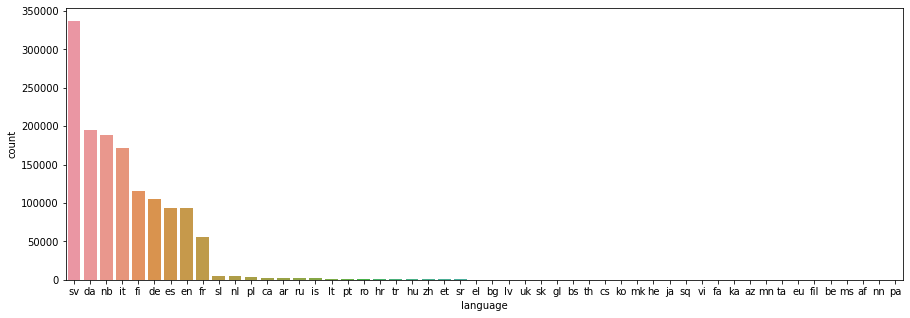

In [31]:
# plot number of languages
fig = plt.figure(figsize = (15, 5))
plt.ticklabel_format(style='plain', axis='y')
sns.countplot(data=df_ep_nps,
              x="language",order=df_ep_nps["language"].value_counts().index );

In [ ]:
df_ep_nps

In [32]:
# check if uder id is unique
sum(df_ep_nps["user_id"].duplicated())

761

It seems that we have users who have taken the survey more than once. This could lead to a bad user experience, since users might get annoyed if they receive the same survey more than once and could effect their score.

In [33]:
df_ep_nps[df_ep_nps["user_id"].duplicated() == True]["user_id"].unique()

array([nan], dtype=object)

The duplicated users were actually not duplicates at all. The user id wasn't correctly tracked or wasn't available and was given the value "none". In analytics platforms such as Amplitude, it is advised to not set user id as "none" when it's not available since all rows with the "none" user id will be considered the same user which leads to false conclusions. 

## Data Cleaning

Since were only interested in conducting the sentiment analysis on rows where written feedback from the user is available, I'll remove all rows with missing feedback and keep only columns useful for the analysis.

In [34]:
# keep only rows where feedback is available
df_ep_nps_clean = df_ep_nps[~df_ep_nps["post_rating_feedback"].isnull()]

# keep only needed columns
df_ep_nps_clean = df_ep_nps_clean[[
                                   'date',
                                   'campaign',
                                   'user_id',
                                   'nps_rating',
                                   'language',
                                   'platform',
                                   'country',
                                   'home_country',
                                   'pre_rating',
                                   'post_rating_feedback',
                                  ]]

In [35]:
df_ep_nps_clean["nps_rating"].unique()

array([nan])

It seems that we don't have and nps rating for users who gave feedback. In this case we need to rely on the pre rating as a label for the feedback (positive or negative).

In [36]:
# drop nps_rating column
df_ep_nps_clean.drop("nps_rating", axis=1, inplace=True)

In [37]:
df_ep_nps_clean["pre_rating"].unique()

array(['thumbs-down', 'thumbs-up', nan], dtype=object)

## Translating Feedback

The dataset includes feedback in 25 different languages. Before we can conduct the sentiment analysis, we'll need to translate the feedback into English first, since most of the NLP libraries and tools are well established for English.

Support for other languages does exist and it is considered best practice to conduct text analyses on the original text language since translating could result in information loss and sometimes even alters the whole semantic meaning of the text. However, given the large number of different languages we're working with, to save some time we'll translate the text to English.

To translate reviews, we'll use the free to use Google Translate API - It's implemented in a Python library called "googletrans" which can be installed and used. 

The library does limit the number of API calls you can make within a certain amount of time. For more information checkout the documentation [here](https://py-googletrans.readthedocs.io/en/latest/).

In [38]:
# check feedback column
df_ep_nps_clean["language"].nunique()

25

In [48]:
df_ep_nps_clean["language"]

20         de
21         en
116        nb
205        de
207        en
           ..
1384169    es
1384284    en
1384285    es
1384828    sv
1385154    sv
Name: language, Length: 8566, dtype: object

In [131]:
# create trasnlator instance
translator = Translator()

def translate_text(text):
    translation = translator.translate(text, dest='en')
    return translation.text    
    

In [133]:
tqdm.pandas()
df_ep_nps_clean["post_rating_feedback_translated"] = df_ep_nps_clean["post_rating_feedback"].progress_apply(translate_text)


100%|███████████████████████████████████████| 8566/8566 [15:15<00:00,  9.35it/s]


## Text Preprocessing

Before we can conduct the sentiment analysis we'll have to first perform some preprocessing which will include:

- Removing "stopwords" (common words that don't give much information such as a, I, the, is, etc.)
- Lowercasing
- Lemmatizing (transform words to their roots)
- Removing digits and punctuation

For this we'll use the NLTK library which provides us with a lot of tools useful for NLP

In [134]:
stopwords.words('english')

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Pipelining

To make the text preprocessing steps more flexible and iterable, well build custom transformer classes to use in our preprocessing pipeline.

In [704]:
# make class for preprocessing (lowercasing and digit removal)
class TextPreprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, lowercase=True,
                 remove_punctuation=True,
                 remove_digits=True,
                 remove_contractions=True):
        
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_digits = remove_digits
        self.remove_contractions = remove_contractions
        
    def fit(self, X, *_):
        return self

    def transform(self, X, *_):
        self.columns = X.columns
        result = X.iloc[:, 0].apply(self.text_preprocessing)
        return pd.DataFrame(result, columns=self.columns)
    
    def fit_transform(self, X, *_):
        self.columns = X.columns
        result = X.applymap(self.text_preprocessing)
        return pd.DataFrame(result, columns=self.columns)

    def get_feature_names_out(self, *args):
        return self.columns.tolist()

    def text_preprocessing(self, text: str) -> str:
        """
        Function to perform text preprocessing steps
        """

        if self.lowercase:
            text = text.lower()
            
        if self.remove_contractions:
            text = contractions.fix(text)
            
        if self.remove_punctuation:
            for punctuation in string.punctuation:
                text = text.replace(punctuation, ' ')# Remove Punctuation
        
        if self.remove_digits:
            tokenized = word_tokenize(text)
            no_numbers = [word for word in tokenized if word.isalpha()]
            text = " ".join(no_numbers)
        
        return text

In [705]:
class WordLemmatizer(BaseEstimator, TransformerMixin):
            
    def fit(self, X, *_):
        return self

    def transform(self, X, *_):
        self.columns = X.columns
        result = X.iloc[:, 0].apply(self.text_lemmatizer)
        return pd.DataFrame(result, columns=self.columns)
    
    def fit_transform(self, X, *_):
        self.columns = X.columns
        result = X.applymap(self.text_lemmatizer)
        return pd.DataFrame(result, columns=self.columns)
    
        
    def get_feature_names_out(self, *args):
        return self.columns.tolist()

    
    def text_lemmatizer(self, text: str) -> str:
        """
        Function to perform text preprocessing steps
        """
        
        lemmatizer = WordNetLemmatizer()
        tokenized = word_tokenize(text)
        
        # lemmatizer requires the correct POS tag to be accurate
        lemmatized = []
        for word, tag in pos_tag(tokenized):
            wntag = tag[0].lower()
            wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
            lemma = lemmatizer.lemmatize(word, wntag) if wntag else word
            
            lemmatized.append(lemma)
                
        return " ".join(lemmatized)

In [706]:
# write transformer for removing stop words
# include option to input list of stopwords that should not be removed

class StopWordRemover(BaseEstimator, TransformerMixin):
    
    def __init__(self, language="english", keep=[]):
        self.language = language
        self.keep = keep
            
    def fit(self, X, *_):
        return self

    def transform(self, X, *_):
        self.columns = X.columns
        result = X.iloc[:, 0].apply(self.remove_stopwords)
        return pd.DataFrame(result, columns=self.columns)
    
    def fit_transform(self, X, *_):
        self.columns = X.columns
        result = X.applymap(self.remove_stopwords)
        return pd.DataFrame(result, columns=self.columns)
    
        
    def get_feature_names_out(self, *args):
        return self.columns.tolist()

    
    def remove_stopwords(self, text: str) -> str:
        """
        Function to remove stopwords
        """
        
        tokenized = word_tokenize(text)
        stop_words = [word for word in set(stopwords.words(self.language)) if not word in self.keep] # Make stopword list
        without_stopwords = [word for word in tokenized if not word in stop_words] # Remove Stop Words
    
        return " ".join(without_stopwords)

In [707]:
# define coulmns in dataframe that should be transformed
features_text = ["post_rating_feedback_translated"]

In [708]:
# clean then lemmatize: 
text_transformer = Pipeline([
    ('processor', TextPreprocessor()),
    ('lemmatizer', WordLemmatizer()),
    ('stopword_remover', StopWordRemover(language="english", keep=["not", "only"]))
    ])

preprocessor = ColumnTransformer([
        ('text_tr', text_transformer, features_text)
                                ])

In [709]:
feedback_preprocessed = preprocessor.fit_transform(df_ep_nps_clean)
df_ep_nps_clean["post_rating_feedback_preprocessed"] = feedback_preprocessed

In [710]:
df_ep_nps_clean.head()

,date,campaign,user_id,language,platform,country,home_country,pre_rating,post_rating_feedback,post_rating_feedback_translated,post_rating_feedback_preprocessed,feedback_sentiment_score
20,2021-12-01,App Rating survey,TVqKk8tryoRsY6HHnlSF4RhSchY7iv2gmx88jJPeIcLooh...,de,android,DE,DE,thumbs-down,Könnte nur im 2 Stundentakt buchen,Could only book every 2 hours,could only book every hour,0.0000
21,2021-12-01,App Rating survey,h90Bqj4rohbielpux0bvspHlSyrv0mEHhw/Q/pyb2PNq5f...,en,android,SE,SE,thumbs-down,Need to pay before you park. Instead of paying...,Need to pay before you park. Instead of paying...,need pay park instead pay leave,-0.1531
116,2021-12-01,App Rating survey,JpCooEKFC51SMcSPCIatwzgxMydTO1QA4q7B2CqlDl4ptz...,nb,ios,NO,NO,thumbs-down,Liker ikke at jeg ikke har kontroll over inn o...,Do not like that I do not have control over th...,not like not control stamping parking lot,-0.2755
205,2021-12-01,App Rating survey,QexnI4pHDssD9v7CGgpFBOqfeEQeXGXKTjYHF5/kh7bLe6...,de,ios,DE,DE,thumbs-down,Apple pay,Apple pay,apple pay,-0.1027
207,2021-12-01,App Rating survey,ijBdoAXRYZbb6YNDM2KSBLylccFMN18bZFHtU7GGClMd/m...,en,android,NO,NO,thumbs-down,Bad,Bad,bad,-0.5423


## Feedback Sentiment Score

To tackle this problem we'll be using the open source VADER library. 

"VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media."

The advantage of using this too is that it has understanding of many sentiment-rich slang words as well as an understanding of degree modifiers such as "very" and exclamation marks.

Manually creating (much less, validating) a comprehensive sentiment lexicon is a labor intensive and sometimes error prone process, so it is no wonder that many opinion mining researchers and practitioners rely so heavily on existing lexicons as primary resources

******[FROM GITHUB DOCUMENTATION](https://github.com/cjhutto/vaderSentiment)******

**About the Scoring**

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05
NOTE: The compound score is the one most commonly used for sentiment analysis by most researchers, including the authors.

In [711]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [712]:
# initialize analyzer bject
analyzer = SentimentIntensityAnalyzer()

Since the VADER analyzer is built to extract sentiment from punctuation, letter cases, exclamations, emojis and contractions, we don't need to take any preprocessing step and should use the translated feedback as they are.

In [713]:
df_ep_nps_clean["feedback_sentiment_score"] = df_ep_nps_clean["post_rating_feedback_translated"].apply(lambda x: analyzer.polarity_scores(x)["compound"])
df_ep_nps_clean[["post_rating_feedback_translated", "feedback_sentiment_score"]]


,post_rating_feedback_translated,feedback_sentiment_score
20,Could only book every 2 hours,0.0000
21,Need to pay before you park. Instead of paying...,-0.1531
116,Do not like that I do not have control over th...,-0.2755
205,Apple pay,-0.1027
207,Bad,-0.5423
...,...,...
1384169,I don't know if I paid twice,0.0000
1384284,Selecting the parking zone has made it difficult,-0.3612
1384285,It never goes well and the wheel is a pain and...,-0.8028
1384828,Very expensive,0.0000


<AxesSubplot:title={'center':'Distribution of Sentiment Score'}, xlabel='feedback_sentiment_score', ylabel='Count'>

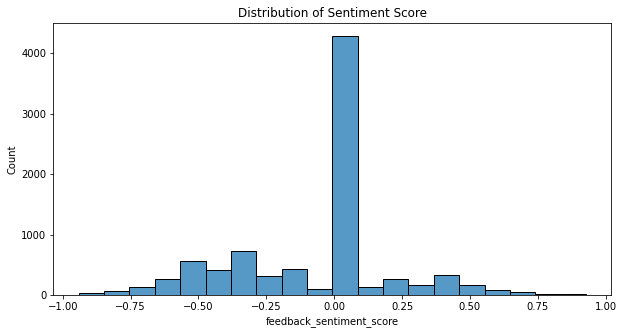

In [804]:
# plot distribution of sentiment score
fig = plt.figure(figsize=(10, 5))
plt.title("Distribution of Sentiment Score")
sns.histplot(data=df_ep_nps_clean,
             x="feedback_sentiment_score",
            bins=20)


###TODO Look only at English reviews

In [1121]:
df_ep_nps_english = df_ep_nps_clean[df_ep_nps_clean["language"]=="en"]

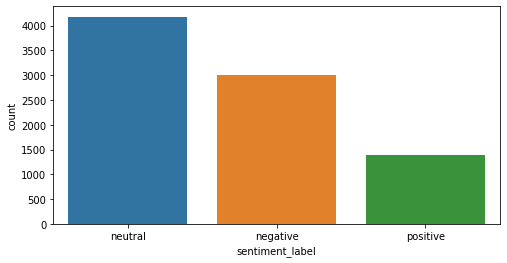

In [830]:
# add column for positiv negative and neutral scores - exclude neutral rating
def label_sentiment(value):
    if value >= 0.05:
        return "positive"
    elif value <= -0.05:
        return "negative"
    return "neutral"

df_ep_nps_clean["sentiment_label"] = df_ep_nps_clean["feedback_sentiment_score"].apply(label_sentiment)

fig = plt.figure(figsize=(8, 4))
sns.countplot(data=df_ep_nps_clean, x="sentiment_label");

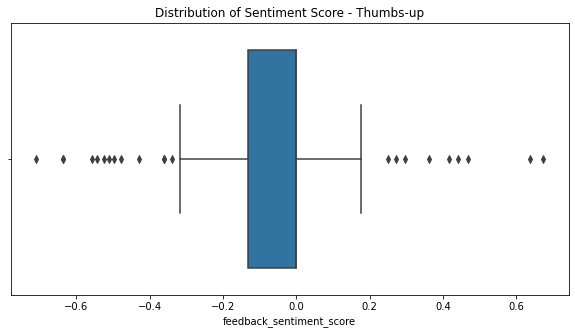

In [801]:
# plot avergage sentiment distrubution
df_thumbs_up = df_ep_nps_clean[df_ep_nps_clean["pre_rating"] == "thumbs-up"]
fig = plt.figure(figsize=(10, 5))
plt.title("Distribution of Sentiment Score - Thumbs-up")
sns.boxplot(data=df_thumbs_up, x="feedback_sentiment_score");

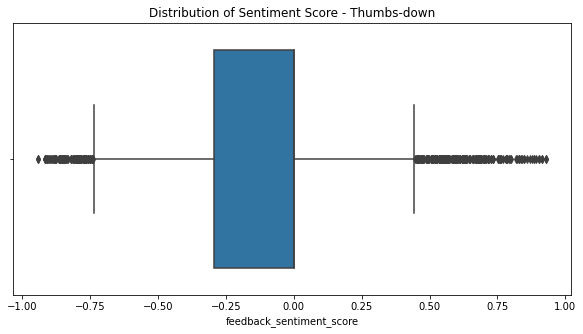

In [800]:
df_thumbs_down = df_ep_nps_clean[df_ep_nps_clean["pre_rating"] == "thumbs-down"]

fig = plt.figure(figsize=(10, 5))
plt.title("Distribution of Sentiment Score - Thumbs-down")
sns.boxplot(data=df_thumbs_down, x="feedback_sentiment_score");

In [ ]:
## use more accurate labels for sentiment

Thumbs-down and thumbs-up tags not accurate indicator of user sentiment

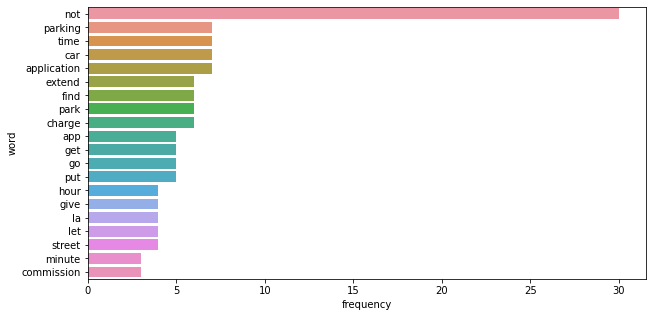

In [716]:
# common words assosiated with thumbs up review

pos_feedback_words = np.array([word.lower() for word in df_thumbs_up["post_rating_feedback_preprocessed"].str.split().sum()])

# remove stop words
pos_feedback_words = [word for word in pos_feedback_words if word not in stop_words]

word_count = np.unique(pos_feedback_words, return_counts=True)
dict(zip(word_count[0],word_count[1]))

df_word_pos_freq = pd.DataFrame({"word":word_count[0], "frequency": word_count[1]})
df_word_pos_freq.sort_values(by="frequency", ascending=False, inplace=True)


# plot positve word frequencies
fig = plt.figure(figsize=(10, 5))
sns.barplot(data=df_word_pos_freq.head(20), y="word", x="frequency");


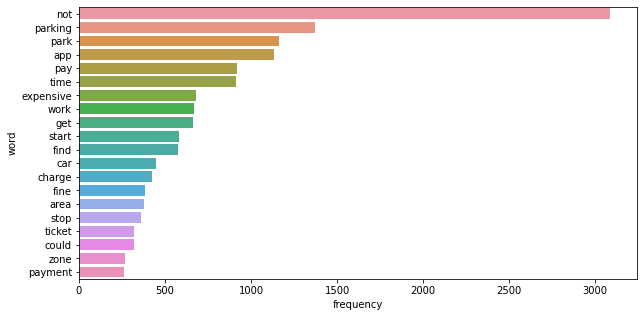

In [717]:
# common words assosiated with thumbs down review

neg_feedback_words = np.array([word.lower() for word in df_thumbs_down["post_rating_feedback_preprocessed"].str.split().sum()])

# remove stop words
neg_feedback_words = [word for word in neg_feedback_words if word not in stop_words]

word_count = np.unique(neg_feedback_words, return_counts=True)
dict(zip(word_count[0],word_count[1]))

df_word_neg_freq = pd.DataFrame({"word":word_count[0], "frequency": word_count[1]})
df_word_neg_freq.sort_values(by="frequency", ascending=False, inplace=True)

# plot negative word frequencies
fig = plt.figure(figsize=(10, 5))
sns.barplot(data=df_word_neg_freq.head(20), y="word", x="frequency");


## Tf-Idf representation with N-grams
Term Frequency - Inverse Document Frequency scores words according to their importance in a text,
according to their presence in a collection of documents.

Instead of considering individual words, N-grams consists of considering word sequences. This
representation captures context. N is the number of words to be consiered as a one.


**Tf-Idf score:**
The higher the numerical weight value, the rarer the term (has more semantic meaning in that particular document). The smaller the weight, the more common the term - the closer it is to 0, the more common a word is.

In [743]:
from sklearn.feature_extraction.text import TfidfVectorizer
feedback_clean = df_ep_nps_clean["post_rating_feedback_preprocessed"].values
feedback_clean_pos = df_ep_nps_clean[df_ep_nps_clean["feedback_sentiment_score"] >= 0.05]

In [816]:
# Tuned TFidfvectorizer
vec = TfidfVectorizer(ngram_range = (3,3), max_df=0.5).fit(feedback_clean)

vectors = vec.transform(feedback_clean) # Transform text to vectors
sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in vec.vocabulary_.items()]  # Get the word and associated weight

# create a list of 3-word-pairings sorted from highest cummulative tfidf score to lowest.
sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

sorted_tfidf_list

[('could not find', 33.57924699696069),
 ('apple pay not', 25.51290692795846),
 ('pay not work', 24.952211933007803),
 ('not find area', 21.727414549671323),
 ('even though pay', 20.30217394899787),
 ('not find parking', 18.99940975669612),
 ('get parking ticket', 18.77041360726752),
 ('app not work', 17.800909792456313),
 ('fin even though', 17.64978547193837),
 ('not find place', 12.081547161669427),
 ('application not work', 11.89639320054326),
 ('app not find', 11.87467988393402),
 ('not start park', 11.81000722341464),
 ('charger not work', 11.374944948110112),
 ('find parking space', 10.920462258920978),
 ('could not start', 10.021653695614374),
 ('not start charge', 10.0),
 ('charge not work', 9.400191787380423),
 ('not find location', 8.771915832912386),
 ('not work well', 8.765099374098316),
 ('not find park', 8.50018654991543),
 ('could not pay', 8.030154153586503),
 ('get fine even', 7.893613258315223),
 ('fine even though', 7.467323420140312),
 ('charge station not', 7.3672

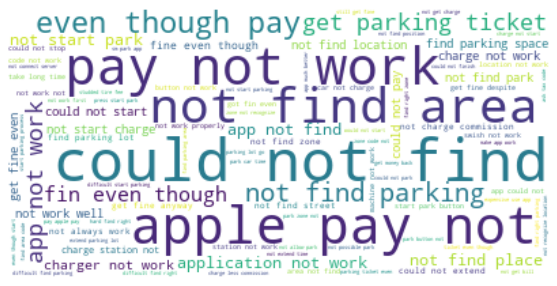

In [820]:
from wordcloud import WordCloud
wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(sorted_tfidf_list))
fig = plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Bonus - Topic Modeling

Latent Dirichlet Allocation

- It's a mathematical model based on the Dirichlet distribution that infers hidden variables and allocates words into topics

- Generates topics based on word frequency in a set of documents. It's useful for finding a mixture of topics within given corpus.

https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf?ref=https://githubhelp.com

In [1113]:
from sklearn.decomposition import LatentDirichletAllocation

# vectorize cleaned text
vectorizer = TfidfVectorizer(ngram_range = (1,1),
                             max_df=0.65,
                             min_df=0.01).fit(feedback_clean)

data_vectorized = vectorizer.transform(texts)

lda_model = LatentDirichletAllocation(n_components=3, max_iter=10).fit(data_vectorized)

In [1114]:
def print_topics_wordcloud(model, vectorizer):
    topic_list = []
    for idx, topic in enumerate(model.components_):
        topic_words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-15 - 1:-1]] # print only the top 10 words per topic
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(dict(topic_words))

        fig = plt.figure(figsize=(8, 4))
        plt.title(f"Topic {idx}")
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.show()

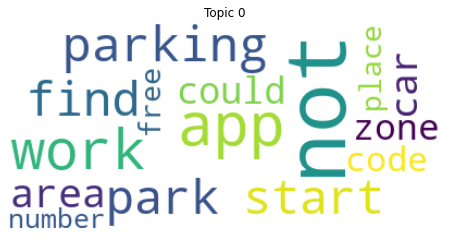

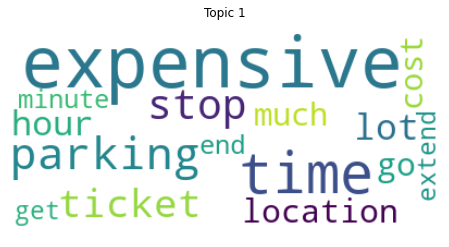

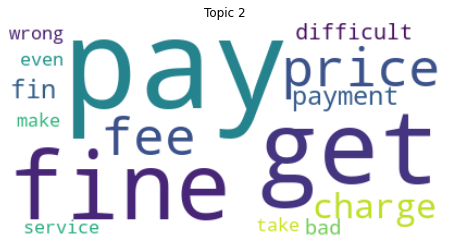

In [1115]:
print_topics_wordcloud(lda_model, vectorizer)

## Categorize new text 

In [1120]:
example = ["parking price"]
example_vectorized = vectorizer.transform(example)
lda_vectors = lda_model.transform(example_vectorized)
for i in range(len(lda_vectors[0])):
    print(f"topic {i} :", lda_vectors[0][i])

topic 0 : 0.19027273491086621
topic 1 : 0.2664898921107098
topic 2 : 0.543237372978424


### Possible Next Steps

- Give each topic a label
   - Was able to identify the following topics:
   
           - Payment
           - Cost/price
           - Parking Space
           
- Use LDA model to label each review


# Open Questions

- We don't have nps rating for all users who have submitted written feedback and all users who don't have feedback have nps rating - Is this an issue during survey collection?